In [2]:
%run "curve_fit_.ipynb"
%run "data_processing_.ipynb"
%run "evaluation_functions_.ipynb"
%run "fitting_functions_.ipynb"
%run "get_temperature_.ipynb"
%run "load_data_.ipynb"
%run "get_backbround_average_.ipynb"
%run "frame_vs_temperature.ipynb"

# Input Files

### input needed: name of the folder containing different velocity's picture

In [2]:
folder = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/Joanne/11092022_1"
folder_2 = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/Joanne/11092022_2"
folder_3 = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/Joanne/11092022_3"
folder_4 = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/Joanne/11092022_4"

In [3]:
all_files, fivemm_files, velocity_path_list, velocity_list, used_frame_num = get_needed_files(folder)
back_intensity_list = get_background_average(fivemm_files)
power_list = get_powers(all_files)

In [4]:
all_files_2, fivemm_files_2, velocity_path_list_2, velocity_list_2, used_frame_num_2 = get_needed_files(folder_2)
back_intensity_list_2 = get_background_average(fivemm_files_2)
power_list_2 = get_powers(all_files_2)

In [5]:
all_files_3, fivemm_files_3, velocity_path_list_3, velocity_list_3, used_frame_num_3 = get_needed_files(folder_3)
back_intensity_list_3 = get_background_average(fivemm_files_3)
power_list_3 = get_powers(all_files_3)

In [6]:
all_files_4, fivemm_files_4, velocity_path_list_4, velocity_list_4, used_frame_num_4 = get_needed_files(folder_4)
back_intensity_list_4 = get_background_average(fivemm_files_4)
power_list_4 = get_powers(all_files_4)

# Get kappa (silicon melt)

### input need: si melting power at specific velocity

In [4]:
Si_melting_W = {
    '103': 49.475,
    '13': 41.8,
    '155': 52.1,
    '190': 53.225, 
    '20': 43.183,
    '234': 54.65,
    '30': 44.2,
    '352': 58.5,
    '45': 46,
    '68': 47.65,
    '9': 42.1
}

### use average dR/R

In [8]:
Si_list = ['103', '13', '155', '20', '30', '45', '68', '9']


Dict_Si_1 = dict((k, fivemm_files[k][10:]) for k in Si_list)
Dict_Si_2 = dict((k, fivemm_files_2[k][10:]) for k in Si_list)
Dict_Si_3 = dict((k, fivemm_files_3[k][10:]) for k in Si_list)
Dict_Si_4 = dict((k, fivemm_files_4[k][10:]) for k in Si_list)

back_intensity_list_Si_1 = []
back_intensity_list_Si_2 = []
back_intensity_list_Si_3 = []
back_intensity_list_Si_4 = []

for key in fivemm_files:
    if key in Si_list:
        index = list(fivemm_files).index(key)
        back_intensity_list_Si_1.append(back_intensity_list[index])
for key in fivemm_files_2:
    if key in Si_list:
        index = list(fivemm_files_2).index(key)
        back_intensity_list_Si_2.append(back_intensity_list_2[index])
for key in fivemm_files_3:
    if key in Si_list:
        index = list(fivemm_files_3).index(key)
        back_intensity_list_Si_3.append(back_intensity_list_3[index])
for key in fivemm_files_4:
    if key in Si_list:
        index = list(fivemm_files_4).index(key)
        back_intensity_list_Si_4.append(back_intensity_list_4[index])

dRoverR_1 = []
dRoverR_2 = []
dRoverR_3 = []
dRoverR_4 = []

for i, v in enumerate(list(Dict_Si_1.keys())):
    con = []
    for file in Dict_Si_1[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si_1[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_1.append(con)

for i, v in enumerate(list(Dict_Si_2.keys())):
    con = []
    for file in Dict_Si_2[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si_2[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_2.append(con)

for i, v in enumerate(list(Dict_Si_3.keys())):
    con = []
    for file in Dict_Si_3[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si_3[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_3.append(con)

for i, v in enumerate(list(Dict_Si_4.keys())):
    con = []
    for file in Dict_Si_4[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si_4[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_4.append(con)

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [9]:
for i in range(0,len(dRoverR_1),1):
    dRoverR_1[i] = dRoverR_1[i][:-1]

for i in range(0,len(dRoverR_2),1):
    dRoverR_2[i] = dRoverR_2[i][:-1]

for i in range(0,len(dRoverR_3),1):
    dRoverR_3[i] = dRoverR_3[i][:-1]

for i in range(0,len(dRoverR_4),1):
    dRoverR_4[i] = dRoverR_4[i][:-1]

In [10]:
for i in range(0, len(Si_list), 1):
    while not (len(dRoverR_1[i]) == len(dRoverR_2[i]) == len(dRoverR_3[i]) == len(dRoverR_4[i])):
        target = min(len(dRoverR_1[i]), len(dRoverR_2[i]), len(dRoverR_3[i]), len(dRoverR_4[i]))
        if len(dRoverR_1[i]) != target:
            dRoverR_1[i] = dRoverR_1[i][:-1]
        if len(dRoverR_2[i]) != target:
            dRoverR_2[i] = dRoverR_2[i][:-1]
        if len(dRoverR_3[i]) != target:
            dRoverR_3[i] = dRoverR_3[i][:-1]
        if len(dRoverR_4[i]) != target:
            dRoverR_4[i] = dRoverR_4[i][:-1]

In [11]:
power_Si= [[] for i in range(len(Si_list))]
for i in range(len(Si_list)):
    power_Si[i] = [29+2*p for p in range(0,len(dRoverR_1[i]),1)]

In [12]:
avg_dRoverR = [[] for i in range(len(Si_list))]
for i in range(len(Si_list)):
    arrays = [dRoverR_1[i], dRoverR_2[i], dRoverR_3[i], dRoverR_4[i]]
    avg_dRoverR[i] = [np.mean(k) for k in zip(*arrays)]

190, 234, 352

In [13]:
Si_list = ['190', '234', '352']


Dict_Si_1 = dict((k, fivemm_files[k][10:]) for k in Si_list)
Dict_Si_2 = dict((k, fivemm_files_2[k][10:]) for k in Si_list)

back_intensity_list_Si_1 = []
back_intensity_list_Si_2 = []

for key in fivemm_files:
    if key in Si_list:
        index = list(fivemm_files).index(key)
        back_intensity_list_Si_1.append(back_intensity_list[index])
for key in fivemm_files_2:
    if key in Si_list:
        index = list(fivemm_files_2).index(key)
        back_intensity_list_Si_2.append(back_intensity_list_2[index])

dRoverR_1 = []
dRoverR_2 = []

for i, v in enumerate(list(Dict_Si_1.keys())):
    con = []
    for file in Dict_Si_1[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si_1[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_1.append(con)

for i, v in enumerate(list(Dict_Si_2.keys())):
    con = []
    for file in Dict_Si_2[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si_2[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_2.append(con)

In [14]:
for i in range(0,len(dRoverR_1),1):
    dRoverR_1[i] = dRoverR_1[i][:-1]

for i in range(0,len(dRoverR_2),1):
    dRoverR_2[i] = dRoverR_2[i][:-1]

In [15]:
for i in range(0, len(Si_list), 1):
    while not (len(dRoverR_1[i]) == len(dRoverR_2[i])):
        target = min(len(dRoverR_1[i]), len(dRoverR_2[i]))
        if len(dRoverR_1[i]) != target:
            dRoverR_1[i] = dRoverR_1[i][:-1]
        if len(dRoverR_2[i]) != target:
            dRoverR_2[i] = dRoverR_2[i][:-1]

In [16]:
power_Si_2= [[] for i in range(len(Si_list))]
for i in range(len(Si_list)):
    power_Si_2[i] = [29+2*p for p in range(0,len(dRoverR_2[i]),1)]

In [17]:
avg_dRoverR_2 = [[] for i in range(len(Si_list))]
for i in range(len(Si_list)):
    arrays = [dRoverR_1[i], dRoverR_2[i]]
    avg_dRoverR_2[i] = [np.mean(k) for k in zip(*arrays)]

In [18]:
avg_dRoverR.insert(3, avg_dRoverR_2[0])

In [19]:
avg_dRoverR.insert(5, avg_dRoverR_2[1])

In [20]:
avg_dRoverR.insert(7, avg_dRoverR_2[2])

In [21]:
power_Si.insert(3, power_Si_2[0])

In [22]:
power_Si.insert(5, power_Si_2[1])

In [23]:
power_Si.insert(7, power_Si_2[2])

In [24]:
for i, v in enumerate(list(Si_melting_W.keys())):
    plt.plot(power_Si[i], avg_dRoverR[i], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_figure_avg/{}mm.png".format(v), format="PNG")
    plt.close()

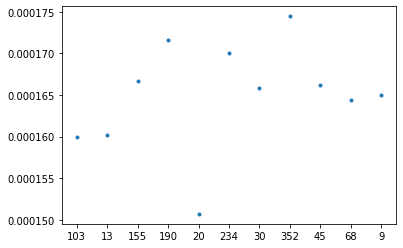

In [25]:
kappa_Si_avg = []
for i, v in enumerate(list(Si_melting_W.keys())):
    popt, pcov = curve_fit(expo, power_Si[i], avg_dRoverR[i], p0 = [1, 0.0000005, 1], maxfev = 8000)
    #a, b, c = popt
    plt.plot(power_Si[i], avg_dRoverR[i], '.')
    y_pred = [expo(j, *popt) for j in power_Si[i]]
    plt.plot(power_Si[i], y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_fit_figure_avg/{}mm.png".format(v), format="PNG")
    plt.close()
    f = expo(Si_melting_W[v], *popt)
    gold_m = 1410
    dT = gold_m - 21
    kappa = f / dT
    kappa_Si_avg.append(kappa)
    
Dict_kappa_Si_avg = dict(zip(list(Si_melting_W.keys()),kappa_Si_avg))

plt.plot(list(Si_melting_W.keys()), kappa_Si_avg, '.')
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/kappa_Si_avg.png", format="PNG")

In [26]:
kappa_Si = sum(kappa_Si_avg)/len(kappa_Si_avg)
kappa_Si

0.00016498400434141028

In [27]:
del avg_dRoverR[5]

In [28]:
del avg_dRoverR[3]

In [29]:
del power_Si[5]

In [30]:
del power_Si[3]

In [31]:
Si_melting_W_2 = {
    '103': 49.475,
    '13': 41.8,
    '155': 52.1,
    '20': 43.183,
    '30': 44.2,
    '352': 58.5,
    '45': 46,
    '68': 47.65,
    '9': 42.1
}

# Fit plane

### with avg kappa

In [32]:
peak_temp_avg = []
for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
    tem = []
    for r in avg_dRoverR[i]:
        t = get_peak_Temp(r, kappa_Si)
        tem.append(t)
    peak_temp_avg.append(tem)
    
Dict_peak_temp_avg = dict(zip(list(Dict_kappa_Si_avg.keys()),peak_temp_avg))

IndexError: list index out of range

In [140]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib


def function(data, a, b, c, d, e):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y)*x**2 + (c+d*y)*x + e

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
    P = [int(p) for p in power_Si[i]]
    V = [np.log(int(v))] * len(Dict_peak_temp_avg[v])
    T = Dict_peak_temp_avg[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
    
parameters, covariance = curve_fit(function, [x_data, y_data], z_data)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
    v_data = [np.log(int(v))] * len(Dict_peak_temp_avg[v])
    p_data = [int(p) for p in power_Si[i]]
    t_data = Dict_peak_temp_avg[v]
    axes.scatter(p_data, v_data, t_data)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX
1538.1789713707917


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_7668/124244824.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


In [141]:
from sympy import symbols, Eq, solve
def get_power(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    x = symbols('x')
    eq1 = Eq((parameters[0]+parameters[1]*lnv)*x**2 + (parameters[2]+parameters[3]*lnv)*x + parameters[4] - Tpeak)
    sol = solve(eq1)
    return sol[1]

In [142]:
get_power(88200/45, 1410)

46.8088065354855

### with each v's kappa

In [250]:
# 這個！

In [33]:
peak_temp = []
for i, v in enumerate(list(Si_melting_W_2.keys())):
    tem = []
    for r in avg_dRoverR[i]:
        t = get_peak_Temp(r, Dict_kappa_Si_avg[v])
        tem.append(t)
    peak_temp.append(tem)
    
Dict_peak_temp = dict(zip(list(Si_melting_W_2.keys()),peak_temp))

In [36]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

def function(data, a, b, c, d, e, f, g, h):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Si_melting_W_2.keys())):
    P = [int(p) for p in power_Si[i]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = z_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters_2, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=10000)
print(parameters_2)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters_2)

z_predicted = function([x_data, y_data], *parameters_2)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

# for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
#     v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
#     p_data = [int(p) for p in power_Si[i]]
#     t_data = Dict_peak_temp[v]
#     axes.scatter(p_data, v_data, t_data, s = 250)
axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)
axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX
[ 2.03584743e-15 -6.73341089e-16  5.61904286e+01 -4.81270605e+00
 -7.81621651e+02  1.08650165e+01  2.90158231e-02  5.61741296e-17]
769.8951459440416


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_1113/285289375.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)
2022-12-05 12:57:07.223 Python[1113:17970] imkxpc_getApplicationProperty:reply: called with incorrect property value 4, bailing.
2022-12-05 12:57:07.223 Python[1113:17970] Text input context does not respond to _valueForTIProperty:
2022-12-05 12:57:07.223 Python[1113:17970] imkxpc_getApplicationProperty:reply: called with incorrect property value 4, bailing.
2022-12-05 12:57:07.223 Python[1113:17970] Text input context does not respond to _valueForTIProperty:
2022-12-05 12:57:37.831 Python[1113:17970] imkxpc_getApplicationProperty:reply:

In [37]:
parameters_2

array([ 2.03584743e-15, -6.73341089e-16,  5.61904286e+01, -4.81270605e+00,
       -7.81621651e+02,  1.08650165e+01,  2.90158231e-02,  5.61741296e-17])

In [161]:
from sympy import symbols, Eq, solve
def get_power_2(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    x = symbols('x')
    eq1 = Eq((parameters_2[0]+parameters_2[1]*lnv)*x**2 
             + (parameters_2[2]+parameters_2[3]*lnv)*x 
             + parameters_2[4] - Tpeak)
    sol = solve(eq1)
    return sol[1]

In [162]:
get_power_2(88200/45, 1410)

46.4959619103084

In [163]:
parameters_2

array([ 3.62190109e+00, -3.28287201e-01, -1.44966532e+02,  6.38711714e+00,
        1.89142687e+03])

In [49]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib


def function(data, a, b, c):
    x = data[0]
    y = data[1]
    return a * (x**b) * (y**c)

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
    P = [int(p) for p in power_Si[i]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
    
parameters, covariance = curve_fit(function, [x_data, y_data], z_data)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
    v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
    p_data = [int(p) for p in power_Si[i]]
    t_data = Dict_peak_temp[v]
    axes.scatter(p_data, v_data, t_data)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX
3732.773541072725


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_7668/3768275443.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


In [26]:
def get_power(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    return (Tpeak / (lnv**parameters[2]) / parameters[0] )**(1/parameters[1])

In [137]:
def line_function(xdata, a, b, c):

    return a * (xdata**2) + b * xdata + c

In [138]:
par, cov = curve_fit(line_function, x_data[0:10], z_data[0:10])
par

array([   1.97450582, -102.83962089, 1612.38348424])

In [139]:
par, cov = curve_fit(line_function, x_data[11:17], z_data[11:17])
par

array([   2.10293291,  -85.15175417, 1208.67383493])

In [140]:
par, cov = curve_fit(line_function, x_data[18:29], z_data[18:29])
par

array([ 2.09146331e+00, -1.23919233e+02,  2.10395325e+03])

In [141]:
par, cov = curve_fit(line_function, x_data[30:36], z_data[30:36])
par

array([   3.13249165, -153.09404304, 2238.43667438])

In [142]:
par, cov = curve_fit(line_function, x_data[37:43], z_data[37:43])
par

array([   3.45382605, -186.68286184, 2917.61734982])

In [143]:
par, cov = curve_fit(line_function, x_data[44:51], z_data[44:51])
par

array([   2.90532962, -158.14133235, 2489.62854347])

In [144]:
par, cov = curve_fit(line_function, x_data[52:60], z_data[52:60])
par

array([   2.37359042, -127.79613055, 2047.71733867])

In [145]:
par, cov = curve_fit(line_function, x_data[61:66], z_data[61:66])
par

array([  1.20558407, -22.26030989, 214.80347488])

In [58]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib


def function(data, a, b, c, d):
    x = np.array(data[0])
    y = np.array(data[1])
    return a * x**b * y**c + d

f = plt.figure(figsize=(30.0, 30.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
    P = [int(p) for p in power_Si[i]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
    
parameters_4, covariance = curve_fit(function, [x_data, y_data], z_data)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters_4)

z_predicted = function([x_data, y_data], *parameters_4)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
    v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
    p_data = [int(p) for p in power_Si[i]]
    t_data = Dict_peak_temp[v]
    axes.scatter(p_data, v_data, t_data)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX
3319.6712136916576


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_7668/782647089.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


In [170]:
def get_power(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    return ((Tpeak-parameters_4[3]) / lnv**parameters_4[2] / parameters_4[0]) **(1/parameters_4[1])

In [183]:
get_power(88200/9, 1410)

39.762154616973184